## Соревнование на kaggle в рамках прохождения практики в компании Wildberries & Russ.

`Черкасов Б. Ю.`

[Ссылка на соревнование](https://www.kaggle.com/competitions/ml-dl-practice/data)

> В современном цифровом мире создание уважительной и безопасной среды общения является важной задачей. В этом соревновании вам предстоит разработать систему, которая будет автоматически выявлять и модерировать нецензурную лексику в пользовательских текстах. При этом, модерировать токсичность не требуется — ваша задача заключается только в выявлении и замене неприемлемых слов.

____

***Задача***:

Вы будете работать с реальными данными, содержащими отзывы и комментарии пользователей, где могут встречаться нецензурные выражения. 

***Цель — выявить и скрыть нецензурные слова и фразы, заменив их на нейтральные символы, обеспечив тем самым чистоту и безопасность общения на платформе***.

Это соревнование моделирует задачи, с которыми сталкиваются системы модерации контента на онлайн-площадках, и ваше решение поможет улучшить пользовательский опыт и повысить безопасность на платформе.
___

***Описание задачи***

Ваше решение должно определить, содержит ли текст нецензурные выражения, и выставить соответствующий бинарный флаг:

$1$ — в тексте есть мат.

$0$ — в тексте нет мата.

Вам предстоит использовать набор данных с текстовыми комментариями и отзывами, где каждый текст уже помечен флагом о наличии или отсутствии мата. Ваша задача — построить модель, которая сможет эффективно решать эту задачу на новых, ранее невиданных данных.

***Пример***:

Оригинальный текст: "Эта юбка полное г…"
Ожидаемый флаг: $1$ (есть мат).
Оригинальный текст: "Эта юбка мне не понравилась."
Ожидаемый флаг: $0$ (мата нет).
Основная метрика

***Решение будет оцениваться с использованием метрики <u>***F1-score***</u>. Эта метрика учитывает как точность, так и полноту предсказаний, что особенно важно в задачах с несбалансированными классами (когда, например, количество текстов с матом может быть меньше, чем без него).***

____

Задачи:

Разработать модель для бинарной классификации текстов, которая предсказывает наличие мата.
Оптимизировать модель с фокусом на повышении метрики F1-score.
Обработать различные виды нецензурных выражений, включая завуалированные и сокращенные формы.
Ожидаемый результат
Модель должна точно предсказывать, содержит ли текст нецензурные выражения, позволяя онлайн-платформам быстро выявлять потенциально неприемлемый контент.

___


Найденные источники по данной теме: 

* [Использование нейронных сетей для бинарной классификации сообщений](https://cyberleninka.ru/article/n/ispolzovanie-neyronnyh-setey-dlya-binarnoy-klassifikatsii-soobscheniy-iz-sotsialnyh-setey-v-sfere-gorodskogo-hozyaystva)

* [Understanding BERT with Hugging Face](https://www.exxactcorp.com/blog/Deep-Learning/understanding-bert-with-hugging-face)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix,
    f1_score, accuracy_score, precision_score, 
    recall_score)
from scipy.sparse import hstack

import torch
import torch.nn as nn

from sklearn.utils.class_weight import compute_class_weight
from transformers.modeling_outputs import SequenceClassifierOutput

from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

from scipy.stats import uniform, randint

from transformers import (
    BertTokenizer,
    BertModel,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)

from sentence_transformers import SentenceTransformer
from datasets import Dataset

from catboost import CatBoostClassifier

In [2]:
# Проверка работы GPU
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 4080 Laptop GPU


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# Пути к файлам 
train_path = r'./train.csv'
test_path = r'./test.csv'

# Формирование датафреймов
train_df = pd.read_csv(train_path, index_col='ID')
test_df = pd.read_csv(test_path, index_col='ID')

train_df

,text,label
ID,,
0,"Брюки отличные, качественные, но к сожалению к...",0
1,"Отличный аппарат, в комплекте кабель и работет...",0
2,Супер 👍 спасибо большое,0
3,Получил быстро данные наушники! К наушникам пр...,0
4,Всё дошло в целости и сохранности),0
...,...,...
240154,крутая хуйня 🤮🤮🤮,1
240155,"Классная бейсболка!!! Пришло всё в целости, уп...",0
240156,Кросовки маломерят. Возврат.,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240159 entries, 0 to 240158
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    240159 non-null  object
 1   label   240159 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.5+ MB


Попробуем применить базовые методы для работы с текстом. 

Используем `TF-IDF` + `Logistic Regression`, где первый компонент представляет собой векторизацию текстовых данных в численный формат, учитывающий важность слов, помимо их частоты встречаемости. Второй же - это **логистическая регрессия**, одна из базовых моделей, применяемых в задаче классификации.

In [7]:
# Делим на train/test
X_train, X_val, y_train, y_val = train_test_split(
    train_df['text'], train_df['label'], test_size=0.2, random_state=42, stratify=train_df['label']
)

# TF-IDF (символы + слова) - стандартная настройка
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5), max_features=50000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

# Обучение 
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

# Оценка
y_val_pred = model.predict(X_val_vec)
print("F1 Score:", f1_score(y_val, y_val_pred))

# Предсказания
X_test_vec = vectorizer.transform(test_df['text'])
test_preds = model.predict(X_test_vec)

# Submission
submission = pd.DataFrame({
    'ID': test_df.index,
    'label': test_preds
})
submission.to_csv('submission.csv', index=False)

F1 Score: 0.876259125773958


Видим, что базовое предположение дало неплохой результат. Попробуем провести ***анализ столбца `text`***, чтобы посмотреть, в каких случаях у нас появляется мат в отзыве, далее составим список. Может пригодиться использование **регулярных выражений**.

Главный ключевой момент в данной задаче - ***feature engineering***, как из слов создать такие фичи, чтобы модель выдавала наилучший результат после обучения.

***Зададим некоторый <u>список паттернов с помощью регулярных выражений</u>, чтобы использовать его для создания численных признаков. Также нарисуем <u>облако слов</u>, чтобы целостно оценить какие слова встречаются в обоих категориях отзывов.***

In [8]:
# Пример грубых выражений для RegEx, шаблон для функции ниже
profanity_patterns = [
    r'\bх[уy][йиёеюя*#@]+\b',      # хуй, ху*, х@й
    r'\bп[иeё][ззcс][ддт]+\b',     # пизда, пецда
    r'\bбл[яа][тд]*\b',            # блядь
    r'\bёб[аоиеую]+\b',            # ёб, ебаный
    r'\bс[уy][кк][ао]*\b',         # сука
    r'\bм[уy][дд][ао]*\b',         # мудак
    r'\bгандон\b',                 # гандон
    r'\bдаун\b',                   # даун
    r'\bеба[лнт][ао]*\b',          # ебало
]

# Функция, которая распознает паттерн матов в тексте
def contains_profanity(text):
    text = str(text).lower()
    for pattern in profanity_patterns:
        if re.search(pattern, text):
            return 1
    return 0

# Добавляем признак в train и test
train_df['contains_profanity'] = train_df['text'].apply(contains_profanity)
test_df['contains_profanity'] = test_df['text'].apply(contains_profanity)

In [9]:
train_df

,text,label,contains_profanity
ID,,,
0,"Брюки отличные, качественные, но к сожалению к...",0,0
1,"Отличный аппарат, в комплекте кабель и работет...",0,0
2,Супер 👍 спасибо большое,0,0
3,Получил быстро данные наушники! К наушникам пр...,0,0
4,Всё дошло в целости и сохранности),0,0
...,...,...,...
240154,крутая хуйня 🤮🤮🤮,1,0
240155,"Классная бейсболка!!! Пришло всё в целости, уп...",0,0
240156,Кросовки маломерят. Возврат.,0,0


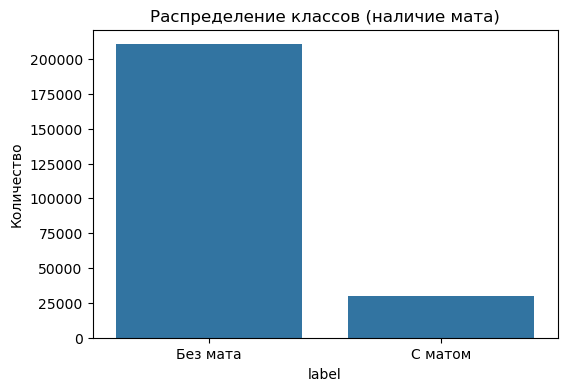


Таблица соответствия истинной метки и regex:


Regex Detected,0,1
True Label,,
0,210397,64
1,28851,847


In [10]:
# Визуализация распределения классов
plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x='label')
plt.title('Распределение классов (наличие мата)')
plt.xticks([0, 1], ['Без мата', 'С матом'])
plt.ylabel('Количество')
plt.show()

# 🔍 Сравнение метки и предсказания regex
comparison = pd.crosstab(train_df['label'], train_df['contains_profanity'], 
                         rownames=['True Label'], colnames=['Regex Detected'])
print("\nТаблица соответствия истинной метки и regex:")
comparison

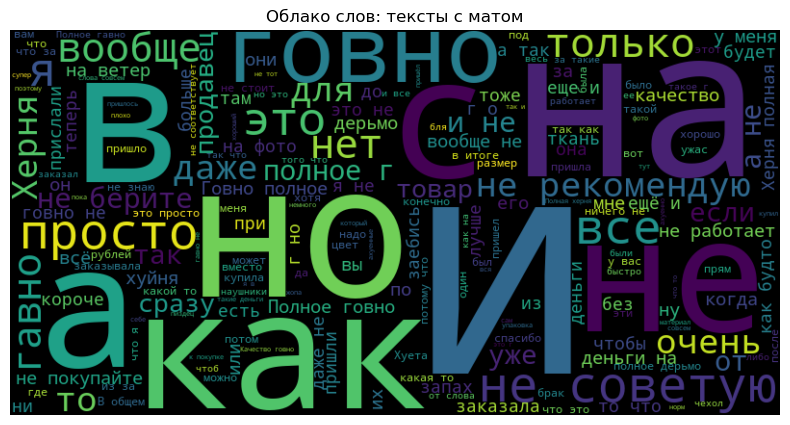

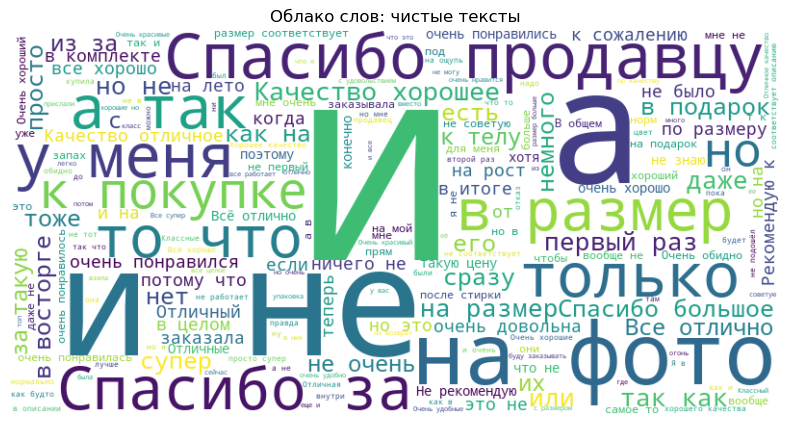

In [11]:
# Облако слов для токсичных отзывов
toxic_texts = " ".join(train_df[train_df['label'] == 1]['text'].dropna().values)
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(toxic_texts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов: тексты с матом')
plt.show()

# Облако слов для чистых сообщений
clean_texts = " ".join(train_df[train_df['label'] == 0]['text'].dropna().values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(clean_texts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов: чистые тексты')
plt.show()

Наблюдается заметный ***дисбаланс классов***, `"правильных отзывов"` гораздо больше `"нехороших"`, что наталкивает на определенные идеи для обучения.

In [13]:
# Признаки и метки
X_text = train_df['text'].fillna('')
y = train_df['label']
X_extra = train_df['contains_profanity'].values.reshape(-1, 1)  # как дополнительный признак

# Разделим на train и val
X_text_train, X_text_val, X_extra_train, X_extra_val, y_train, y_val = train_test_split(
    X_text, X_extra, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF векторизация
vectorizer = TfidfVectorizer(
    analyzer='char_wb',
    max_features=50000,
    ngram_range=(3, 5),
    lowercase=True
)
X_tfidf_train = vectorizer.fit_transform(X_text_train)
X_tfidf_val = vectorizer.transform(X_text_val)

# Объединяем текстовые и доп. признаки
X_train_combined = hstack([X_tfidf_train, X_extra_train])
X_val_combined = hstack([X_tfidf_val, X_extra_val])

# Обучение
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train_combined, y_train)

# Оценка
y_pred = model.predict(X_val_combined)
f1 = f1_score(y_val, y_pred)
print(f"🔍 F1-score на валидации: {f1:.4f}")

🔍 F1-score на валидации: 0.9014


In [22]:
# Детальный отчёт
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     42092
           1       0.86      0.94      0.90      5940

    accuracy                           0.97     48032
   macro avg       0.93      0.96      0.94     48032
weighted avg       0.98      0.97      0.97     48032



Видно, что дополнительные предположения о введении специального словаря ***"плохих слов"*** позволил несколько улучшить результат.

In [15]:
# Подготовим тестовые данные для оценки
X_test_text = test_df['text'].fillna('')
X_test_extra = test_df['contains_profanity'].values.reshape(-1, 1)

X_test_tfidf = vectorizer.transform(X_test_text)

X_test_combined = hstack([X_test_tfidf, X_test_extra])

# Предсказание
test_preds = model.predict(X_test_combined)

# submission1
submission = pd.DataFrame({
    'ID': test_df.index,
    'label': test_preds
})
submission.to_csv('submission1.csv', index=False)

[![res1.png](https://iimg.su/s/10/2wBhdf2zQTZfBwWMEUzxPXx5AlMRTK9mLbjhpc8w.png)](https://iimg.su/i/JAhTMt)

Результат улучшился на $0.3$ с предыдущего раза.

In [16]:
# Посмотрим на количество слов
pd.DataFrame(train_df['text'].value_counts())

,count
text,
👍,1070
Супер,810
Говно,576
👍👍👍,444
Отлично,403
...,...
"Наверно это одни из самых вкусных кокосовых батончиков без сахара(а перепробовала я много разных) кокос не сухой, чем то похож на Баунти, батончики мягкие! Однозначно вкусно!",1
"Сделано во Франции, но написано- в Англии 😅 кому верить?) На самом деле тушь хорошая! Я большая поклонница фирмы Макс Фактор, пользуюсь ей с первой туши 2000 calories с изогнутой кисточкой, позже она претерпела перевыпуск и не в лучшую сторону, на мой взгляд. Ничего, смирилась... тут решила попробовать эту тушь и, надо сказать, она меня порадовала. Реснички разделяет, удлиняет, кисточка удобная, будто всегда ей пользовалась. Отличная альтернатива 2000 calories, если для вас это важно, как и для меня ❤️",1
"Химозный состав. Нога потеет. При этом тонкие, даже просвечиваются. В ботинках трутся, по полу скользят. Не комфортно. Обидно, что заказал 24 штуки сразу. Носить невозможно. Не советую…",1


#### Улучшение Feature Engineering + TF-IDF + LogisticRegression

In [5]:
# Загрузка
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Создание признаков
def extract_features(df):
    df = df.copy()
    df["text_len"] = df["text"].apply(len)
    df["num_exclam"] = df["text"].str.count("!")
    df["num_question"] = df["text"].str.count("\\?")
    df["num_upper"] = df["text"].apply(lambda x: sum(1 for c in x if c.isupper()))
    df["contains_profanity"] = df["text"].apply(lambda x: int(bool(re.search(r"\b(х[уy]|пиз|бля|еб)\w*", x.lower()))))
    return df

train_df = extract_features(train_df)
test_df = extract_features(test_df)

# Разделение
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop(columns=["label", "ID"]),
    train_df["label"],
    test_size=0.2,
    stratify=train_df["label"],
    random_state=42
)

# Колонки
text_column = "text"
num_columns = ["text_len", "num_exclam", "num_question", "num_upper", "contains_profanity"]

# Преобразователь
preprocessor = ColumnTransformer([
    ("tfidf", TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 5), max_features=50000), "text"),
    ("num", "passthrough", num_columns)
])

# Модель
clf = Pipeline([
    ("features", preprocessor),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=10000, C=1.0))
])

# Обучение
clf.fit(X_train, y_train)

# Предсказания
y_pred = clf.predict(X_val)

# Метрики
print("F1:", f1_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

F1: 0.9029976693723378
Precision: 0.8639089650930339
Recall: 0.9457912457912457
Accuracy: 0.9748709193870753


In [10]:
# Предсказания
# X_test_vec = preprocessor.transform(test_df['text'])
test_preds = clf.predict(test_df)

# Submission
submission = pd.DataFrame({
    'ID': test_df.index,
    'label': test_preds
})
submission.to_csv('submission2.csv', index=False)

[![res2.png](https://iimg.su/s/11/4ErDBEIiNVXlfhrGoE9uFKfYv1x0xHahg8NAYpXS.png)](https://iimg.su/i/6GRmKf)

#### Усиление с Xgboost

In [15]:
# Загрузка
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Feature Engineering
def extract_features(df):
    df = df.copy()
    df["text_len"] = df["text"].apply(len)
    df["num_exclam"] = df["text"].str.count("!")
    df["num_question"] = df["text"].str.count(r"\?")
    df["num_upper"] = df["text"].apply(lambda x: sum(1 for c in x if c.isupper()))
    df["num_words"] = df["text"].apply(lambda x: len(x.split()))
    df["contains_profanity"] = df["text"].apply(lambda x: int(bool(re.search(r"\b(х[уy]|пиз|бля|еб)\w*", x.lower()))))
    df["upper_ratio"] = df["num_upper"] / df["text_len"].replace(0, 1)
    df["punct_ratio"] = df["text"].str.count(r"[!?,.:;]").astype(float) / df["text_len"].replace(0, 1)
    return df

train_df = extract_features(train_df)
test_df = extract_features(test_df)

# Разделение
X = train_df.drop(columns=["label", "ID"])
y = train_df["label"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# TF-IDF только по train
tfidf = TfidfVectorizer(analyzer='char_wb', max_features=50000, ngram_range=(3, 5))
tfidf.fit(X_train["text"])

X_train_tfidf = tfidf.transform(X_train["text"])
X_val_tfidf = tfidf.transform(X_val["text"])
X_test_tfidf = tfidf.transform(test_df["text"])

# Удаляем текст, оставляем доп признаки
X_train_feats = X_train.drop(columns=["text"]).reset_index(drop=True)
X_val_feats = X_val.drop(columns=["text"]).reset_index(drop=True)
X_test_feats = test_df.drop(columns=["text", "ID"]).reset_index(drop=True)

X_train_all = hstack([X_train_tfidf, X_train_feats])
X_val_all = hstack([X_val_tfidf, X_val_feats])
X_test_all = hstack([X_test_tfidf, X_test_feats])

# XGBoost
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=1.5, 
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

# Обучение
model.fit(X_train_all, y_train)

# Предсказание
y_pred = model.predict(X_val_all)

# Метрики
print("F1:", f1_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

c:\Users\boris\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:07:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1: 0.9313940243581881
Precision: 0.9711310067604605
Recall: 0.8947811447811448
Accuracy: 0.9836983677548301


In [16]:
# Предсказания на тесте
test_preds = model.predict(X_test_all)

# Сохранение
submission = pd.DataFrame({
    "ID": test_df["ID"],
    "label": test_preds
})
submission.to_csv("submission_xgb.csv", index=False)

[![res3.png](https://iimg.su/s/11/04DrZmnuHYEHbtslomqVbQXZ6KuRjcUC6aylKmkk.png)](https://iimg.su/i/PyEL9I)

Градиентный бустинг помогает `почти бесплатно` получить хороший результат. Попробуем организовать перебор параметров, чтобы посмотреть как сильно от этого результат изменится.

In [5]:
# Загрузка
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Feature Engineering
def extract_features(df):
    df = df.copy()
    df["text_len"] = df["text"].apply(len)
    df["num_exclam"] = df["text"].str.count("!")
    df["num_question"] = df["text"].str.count(r"\?")
    df["num_upper"] = df["text"].apply(lambda x: sum(1 for c in x if c.isupper()))
    df["num_words"] = df["text"].apply(lambda x: len(x.split()))
    df["contains_profanity"] = df["text"].apply(lambda x: int(bool(re.search(r"\b(х[уy]|пиз|бля|еб)\w*", x.lower()))))
    df["upper_ratio"] = df["num_upper"] / df["text_len"].replace(0, 1)
    df["punct_ratio"] = df["text"].str.count(r"[!?,.:;]").astype(float) / df["text_len"].replace(0, 1)
    return df

train_df = extract_features(train_df)
test_df = extract_features(test_df)

# Разделение
X = train_df.drop(columns=["label", "ID"])
y = train_df["label"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# TF-IDF только по train
tfidf = TfidfVectorizer(analyzer='char_wb', max_features=50000, ngram_range=(3, 5))
tfidf.fit(X_train["text"])

X_train_tfidf = tfidf.transform(X_train["text"])
X_val_tfidf = tfidf.transform(X_val["text"])
X_test_tfidf = tfidf.transform(test_df["text"])

# Удаляем текст, оставляем доп признаки
X_train_feats = X_train.drop(columns=["text"]).reset_index(drop=True)
X_val_feats = X_val.drop(columns=["text"]).reset_index(drop=True)
X_test_feats = test_df.drop(columns=["text", "ID"]).reset_index(drop=True)

X_train_all = hstack([X_train_tfidf, X_train_feats])
X_val_all = hstack([X_val_tfidf, X_val_feats])
X_test_all = hstack([X_test_tfidf, X_test_feats])

In [7]:
# Параметры для RandomizedSearch
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'scale_pos_weight': uniform(1, 3),
    'gamma': uniform(0, 5)
}

xgb_model = XGBClassifier(
    eval_metric="logloss",
    random_state=42
)

search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    n_jobs=1,
    cv=3,
    verbose=1,
    random_state=42
)

# Подбор параметров
search.fit(X_train_all, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\boris\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\boris\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\boris\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\boris\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\boris\an

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B7AEE37A70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B7AE6F5790>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001B7ADD63170>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001B7AD9B0D70>},
                   random_state=42, scoring='f1', verbose=1)

In [8]:
# Лучшая модель
best_model = search.best_estimator_

# Метрики на валидации
y_pred = best_model.predict(X_val_all)
print("F1:", f1_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

# Сохранение предсказаний
test_preds = best_model.predict(X_test_all)
submission = pd.DataFrame({
    "ID": test_df["ID"],
    "label": test_preds
})
submission.to_csv("submission_xgb_tuned.csv", index=False)

F1: 0.9427987742594485
Precision: 0.9535123966942148
Recall: 0.9323232323232323
Accuracy: 0.9860093271152565


[![res4.png](https://iimg.su/s/11/3HiGmiRujBoIwAeWL5CzQE1t8AVy46vJPWdtNbx7.png)](https://iimg.su/i/xdUwfh)

In [ ]:
# Сохраняем лучшие параметры Xgboost на всякий случай
best_xgb_params = best_model.get_params()
best_xgb_params

# {'objective': 'binary:logistic',
#  'base_score': None,
#  'booster': None,
#  'callbacks': None,
#  'colsample_bylevel': None,
#  'colsample_bynode': None,
#  'colsample_bytree': 0.77261658145345,
#  'device': None,
#  'early_stopping_rounds': None,
#  'enable_categorical': False,
#  'eval_metric': 'logloss',
#  'feature_types': None,
#  'feature_weights': None,
#  'gamma': 3.360677737029393,
#  'grow_policy': None,
#  'importance_type': None,
#  'interaction_constraints': None,
#  'learning_rate': 0.23848588459861528,
#  'max_bin': None,
#  'max_cat_threshold': None,
#  'max_cat_to_onehot': None,
#  'max_delta_step': None,
#  'max_depth': 5,
#  'max_leaves': None,
#  'min_child_weight': None,
#  'missing': nan,
#  'monotone_constraints': None,
#  'multi_strategy': None,
#  'n_estimators': 354,
#  'n_jobs': None,
#  'num_parallel_tree': None,
#  'random_state': 42,
#  'reg_alpha': None,
#  'reg_lambda': None,
#  'sampling_method': None,
#  'scale_pos_weight': 3.4094192691396876,
#  'subsample': 0.8410901903338115,
#  'tree_method': None,
#  'validate_parameters': None,
#  'verbosity': None}

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.77261658145345,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'feature_weights': None,
 'gamma': 3.360677737029393,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.23848588459861528,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 354,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 3.4094192691396876,
 'subsample': 0.8410901903338115,
 'tree_method': None,
 'validate_paramete

Попробуем воспользоваться `BERT` ***(Bidirectional Encoder Representations from Transformers)*** - модель обработки естественного языка, построенная на архитектуре трансформеров.


* [BERT](https://huggingface.co/docs/transformers/model_doc/bert)

![Diff Bert vs ChatGPT](https://1.bp.blogspot.com/-jDxr5u8TpUk/X-lAz7hmM7I/AAAAAAAAJLQ/05FF29xWHA422tThePNTfM-4h8VO0SphgCLcBGAsYHQ/s2624/BERT.png)

In [19]:
# Загрузка данных
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Тексты и метки
X = train_df["text"].tolist()
y = train_df["label"].tolist()
X_test = test_df["text"].tolist()

# Разделение
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Загрузка модели (можно заменить на 'paraphrase-multilingual-MiniLM-L12-v2' или 'cointegrated/rubert-tiny2')
model = SentenceTransformer("DeepPavlov/rubert-base-cased-sentence")

# Если есть GPU:
model = model.to("cuda")

# Получение эмбеддингов
X_train_emb = model.encode(X_train, batch_size=32, show_progress_bar=True, device="cuda")
X_val_emb = model.encode(X_val, batch_size=32, show_progress_bar=True, device="cuda")
X_test_emb = model.encode(X_test, batch_size=32, show_progress_bar=True, device="cuda")

No sentence-transformers model found with name DeepPavlov/rubert-base-cased-sentence. Creating a new one with mean pooling.


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

c:\Users\boris\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\boris\.cache\huggingface\hub\models--DeepPavlov--rubert-base-cased-sentence. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
# Xgboost
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    tree_method="hist",  # или "gpu_hist" если CUDA
    device="cuda"        # ускорение на GPU
)

xgb_model.fit(X_train_emb, y_train)

# Предсказания
y_val_pred = xgb_model.predict(X_val_emb)
f1 = f1_score(y_val, y_val_pred)

print(f"🔍 F1 на валидации (BERT + XGBoost): {f1:.4f}")# Модель
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    tree_method="hist",  # или "gpu_hist" если CUDA
    device="cuda"        # ускорение на GPU
)

xgb_model.fit(X_train_emb, y_train)

# Предсказания
y_val_pred = xgb_model.predict(X_val_emb)
f1 = f1_score(y_val, y_val_pred)

print(f"🔍 F1 на валидации (BERT + XGBoost): {f1:.4f}")

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
# Проверим логистическую регрессию

scaler = StandardScaler()

X_train_emb_scaled = scaler.fit_transform(X_train_emb)
X_val_emb_scaled = scaler.transform(X_val_emb)

# Модель
log_reg_cls = LogisticRegression(class_weight='balanced', max_iter=10000)

log_reg_cls.fit(X_train_emb_scaled, y_train)

# Предсказания
y_val_pred = log_reg_cls.predict(X_val_emb_scaled)
f1 = f1_score(y_val, y_val_pred)

print(f"🔍 F1 на валидации (BERT + LogReg): {f1:.4f}")

🔍 F1 на валидации (BERT + LogReg): 0.6267


#### Применение BertClassificationModel

In [25]:
# Загрузка данных
df = pd.read_csv("train.csv")
df = df.drop(columns=["ID"], errors="ignore")

# Разделение на train/val
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# Токенизатор
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

# Применение токенизации
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Модель
model = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=2)

# Аргументы обучения
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    logging_dir="./logs",
)


def compute_metrics(pred):
    preds = torch.argmax(torch.tensor(pred.predictions), axis=1)
    labels = pred.label_ids
    return {"f1": f1_score(labels, preds, average="macro")}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

# Обучение
trainer.train()

Map:   0%|          | 0/192127 [00:00<?, ? examples/s]

Map:   0%|          | 0/48032 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.058100,0.060220,0.970567
2,0.040000,0.059539,0.973288
3,0.028400,0.061154,0.973822
4,0.016300,0.068523,0.972689


TrainOutput(global_step=48032, training_loss=0.040482046402777375, metrics={'train_runtime': 6957.2773, 'train_samples_per_second': 110.461, 'train_steps_per_second': 6.904, 'total_flos': 5.055073773315072e+16, 'train_loss': 0.040482046402777375, 'epoch': 4.0})

In [26]:
val_preds = trainer.predict(val_dataset)
val_logits = val_preds.predictions
val_pred_labels = np.argmax(val_logits, axis=1)

val_f1 = f1_score(val_labels, val_pred_labels)
print(f"BERT: F1 score на валидации: {val_f1:.4f}")
print(f"Отчет: {classification_report(val_labels, val_pred_labels)}")

BERT: F1 score на валидации: 0.9541
Отчет:               precision    recall  f1-score   support

           0       0.99      0.99      0.99     42092
           1       0.96      0.95      0.95      5940

    accuracy                           0.99     48032
   macro avg       0.98      0.97      0.97     48032
weighted avg       0.99      0.99      0.99     48032



In [32]:
# Загрузка тестового датасета
test_df = pd.read_csv("test.csv")
test_texts = test_df["text"].tolist()

# Токенизация
test_dataset = Dataset.from_dict({"text": test_texts})
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Предсказания
preds = trainer.predict(test_dataset)
bert_logits = preds.predictions
bert_preds = np.argmax(bert_logits, axis=1)

submission = pd.DataFrame({
    "ID": test_df['ID'],
    'label': bert_preds
})

submission.to_csv('submission_bert.csv', index=False)

Map:   0%|          | 0/60040 [00:00<?, ? examples/s]

[![res5.png](https://iimg.su/s/11/UGcYOUyvUW5AtFaKHAbrwKFpcqIHN4bmYn8OTCnR.png)](https://iimg.su/i/NG8Ni6)

#### Усиление Xgboost + BERT

In [7]:
best_xgb_params = {'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.77261658145345,
 'device': 'cuda', #None
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'feature_weights': None,
 'gamma': 3.360677737029393,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.23848588459861528,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': np.nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 354,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 3.4094192691396876,
 'subsample': 0.8410901903338115,
 'tree_method': 'hist', #None
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
# # Загрузка данных
# df = pd.read_csv("train.csv")
# df = df.drop(columns=["ID"], errors="ignore")

# # Разделение на train/val
# train_texts, val_texts, train_labels, val_labels = train_test_split(
#     df["text"].tolist(),
#     df["label"].tolist(),
#     test_size=0.2,
#     stratify=df["label"],
#     random_state=42
# )

# # Токенизатор
# tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

# # Применение токенизации
# def tokenize_function(example):
#     return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

# train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
# val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

# train_dataset = train_dataset.map(tokenize_function, batched=True)
# val_dataset = val_dataset.map(tokenize_function, batched=True)

# train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
# val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# # Модель
# model = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=2)

Map:   0%|          | 0/192127 [00:00<?, ? examples/s]

Map:   0%|          | 0/48032 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
test_df = pd.read_csv('./test.csv')
test_texts = test_df["text"].tolist()

In [ ]:
# # ===== TF-IDF =====
# tfidf = TfidfVectorizer(analyzer='char_wb', max_features=50000, ngram_range=(3, 5))
# X_train_tfidf = tfidf.fit_transform(train_texts)
# X_val_tfidf = tfidf.transform(val_texts)
# X_test_tfidf = tfidf.transform(test_texts)

In [8]:
# Загрузка
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Feature Engineering
def extract_features(df):
    df = df.copy()
    df["text_len"] = df["text"].apply(len)
    df["num_exclam"] = df["text"].str.count("!")
    df["num_question"] = df["text"].str.count(r"\?")
    df["num_upper"] = df["text"].apply(lambda x: sum(1 for c in x if c.isupper()))
    df["num_words"] = df["text"].apply(lambda x: len(x.split()))
    df["contains_profanity"] = df["text"].apply(lambda x: int(bool(re.search(r"\b(х[уy]|пиз|бля|еб)\w*", x.lower()))))
    df["upper_ratio"] = df["num_upper"] / df["text_len"].replace(0, 1)
    df["punct_ratio"] = df["text"].str.count(r"[!?,.:;]").astype(float) / df["text_len"].replace(0, 1)
    return df

train_df = extract_features(train_df)
test_df = extract_features(test_df)

# Разделение
X = train_df.drop(columns=["label", "ID"])
y = train_df["label"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# TF-IDF только по train
tfidf = TfidfVectorizer(analyzer='char_wb', max_features=50000, ngram_range=(3, 5))
tfidf.fit(X_train["text"])

X_train_tfidf = tfidf.transform(X_train["text"])
X_val_tfidf = tfidf.transform(X_val["text"])
X_test_tfidf = tfidf.transform(test_df["text"])

# Удаляем текст, оставляем доп признаки
X_train_feats = X_train.drop(columns=["text"]).reset_index(drop=True)
X_val_feats = X_val.drop(columns=["text"]).reset_index(drop=True)
X_test_feats = test_df.drop(columns=["text", "ID"]).reset_index(drop=True)

X_train_all = hstack([X_train_tfidf, X_train_feats])
X_val_all = hstack([X_val_tfidf, X_val_feats])
X_test_all = hstack([X_test_tfidf, X_test_feats])

In [9]:
xgb_best_model = XGBClassifier(**best_xgb_params)
xgb_best_model.fit(X_train_all, y_train)

# Метрики на валидации
y_pred = xgb_best_model.predict(X_val_all)
print("F1:", f1_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

F1: 0.9435504469987228
Precision: 0.9545219638242894
Recall: 0.9328282828282828
Accuracy: 0.9861967021985343


In [10]:
# Берем ансамбль, поэтому нужны вероятности
xgb_val_probs = xgb_best_model.predict_proba(X_val_all)[:, 1]
xgb_test_probs = xgb_best_model.predict_proba(X_test_all)[:, 1]

In [ ]:
# # ===== CatBoost =====
# cat_model = CatBoostClassifier(
#     iterations=300,
#     depth=5,
#     learning_rate=0.05,
#     loss_function='Logloss',
#     eval_metric='F1',
#     verbose=0,
#     task_type="GPU"
# )

# cat_model.fit(X_train_tfidf, train_labels, eval_set=(X_val_tfidf, val_labels))
# cat_val_probs = cat_model.predict_proba(X_val_tfidf)[:, 1]
# cat_test_probs = cat_model.predict_proba(X_test_tfidf)[:, 1]

In [24]:
# Загрузка данных
df = pd.read_csv("train.csv")
df = df.drop(columns=["ID"], errors="ignore")

# Разделение на train/val
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# Токенизатор
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

# Применение токенизации
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Модель
model = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=2)

Map:   0%|          | 0/192127 [00:00<?, ? examples/s]

Map:   0%|          | 0/48032 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Аргументы обучения
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    logging_dir="./logs",
)


def compute_metrics(pred):
    preds = torch.argmax(torch.tensor(pred.predictions), axis=1)
    labels = pred.label_ids
    return {"f1": f1_score(labels, preds, average="macro")}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

# Обучение
trainer.train()

In [ ]:
# Загружаем обученную ранее модель
checkpoint_path = "./results/checkpoint-48032"
model = BertForSequenceClassification.from_pretrained(checkpoint_path)
model.eval()
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# Получаем вероятности на валидации
val_loader = DataLoader(val_dataset, batch_size=32)

all_probs = []

with torch.no_grad():
    for batch in tqdm(val_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        all_probs.append(probs[:, 1].cpu().numpy())  # [:, 1] — вероятность положительного класса

# Склеиваем всё в один массив
bert_val_probs = np.concatenate(all_probs)

100%|██████████| 1501/1501 [01:27<00:00, 17.20it/s]


In [32]:
# Загрузка тестового датасета
test_df = pd.read_csv("test.csv")
test_texts = test_df["text"].tolist()

# Токенизация
test_dataset = Dataset.from_dict({"text": test_texts})
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

Map:   0%|          | 0/60040 [00:00<?, ? examples/s]

In [ ]:
# Получаем вероятности на тесте
test_loader = DataLoader(test_dataset, batch_size=32)

all_test_probs = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        all_test_probs.append(probs[:, 1].cpu().numpy())

bert_test_probs = np.concatenate(all_test_probs)

100%|██████████| 1877/1877 [01:48<00:00, 17.22it/s]


In [38]:
from sklearn.metrics import f1_score

# Усреднение
ensemble_probs = (bert_val_probs + xgb_val_probs) / 2

# Превращаем в метки: порог можно варьировать
ensemble_preds = (ensemble_probs > 0.5).astype(int)

# Считаем F1
f1 = f1_score(val_labels, ensemble_preds)
print(f"F1 score (ensemble): {f1:.4f}")

F1 score (ensemble): 0.9566


In [ ]:
# Решаем задачу нахождения оптимального веса
def find_best_ensemble_weight(bert_probs, xgb_probs, true_labels):
    best_f1 = 0
    best_alpha = 0
    for alpha in np.linspace(0, 1, 101):
        ensemble_probs = alpha * bert_probs + (1 - alpha) * xgb_probs
        preds = (ensemble_probs >= 0.5).astype(int)
        f1 = f1_score(true_labels, preds, average='macro')
        if f1 > best_f1:
            best_f1 = f1
            best_alpha = alpha
    return best_alpha, best_f1

best_alpha, best_f1 = find_best_ensemble_weight(bert_val_probs, xgb_val_probs, val_labels)
print(f"Лучший alpha: {best_alpha}, F1 на валидации: {best_f1:.4f}")

Лучший alpha: 0.49, F1 на валидации: 0.9764


In [36]:
# ====== 4. Ансамбль с найденным best_alpha ======
ensemble_test_probs = best_alpha * bert_test_probs + (1 - best_alpha) * xgb_test_probs
ensemble_test_preds = (ensemble_test_probs > 0.5).astype(int)

# ====== 5. Создание submission.csv ======
submission_df = pd.DataFrame({
    'ID': test_df['ID'],
    'label': ensemble_test_preds
})

submission_df.to_csv("submission_bert_xgb_ensemble.csv", index=False)
print(f"✅ Submission создан с alpha = {best_alpha:.3f}")

✅ Submission создан с alpha = 0.490


#### Интеграция RoBERTA в ансамбль

In [ ]:
# from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
# import torch
# from torch.utils.data import DataLoader, Dataset

# # Загружаем токенизатор DistilBERT
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# train_dataset = train_dataset.map(tokenize_function, batched=True)
# val_dataset = val_dataset.map(tokenize_function, batched=True)

# # Убираем ненужные колонки
# train_dataset = train_dataset.remove_columns(["text"])
# val_dataset = val_dataset.remove_columns(["text"])

# # Устанавливаем формат для PyTorch
# train_dataset.set_format("torch")
# val_dataset.set_format("torch")

# # Загружаем модель для классификации (2 класса)
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\boris\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\boris\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/192127 [00:00<?, ? examples/s]

Map:   0%|          | 0/48032 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# # Параметры тренировки
# training_args = TrainingArguments(
#     output_dir="./disbert_results",
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=32,
#     num_train_epochs=3,
#     weight_decay=0.01,
#     load_best_model_at_end=True,
#     metric_for_best_model="f1",
# )

# def compute_metrics(pred):
#     preds = torch.argmax(torch.tensor(pred.predictions), axis=1)
#     labels = pred.label_ids
#     return {"f1": f1_score(labels, preds, average="macro")}

# # Создаём тренера
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     compute_metrics=compute_metrics,
# )

# # Обучение
# trainer.train()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# # Предсказания на валидации (вероятности)
# preds_output = trainer.predict(val_dataset)
# logits = preds_output.predictions
# probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()

# print("F1 macro на валидации:", preds_output.metrics['test_f1'])

In [ ]:
# import numpy as np
# from sklearn.metrics import f1_score
# from scipy.optimize import minimize

# # Пример: probs_bert, probs_xgb, probs_roberta уже вычислены и имеют shape (N, 2)
# # y_val — истинные метки

# def ensemble_f1(weights, probs_list, y_true):
#     # weights — массив с весами для каждой модели
#     # probs_list — список вероятностей каждой модели, shape (N, num_classes)
#     # Считаем взвешенное среднее вероятностей
#     weighted_probs = np.zeros_like(probs_list[0])
#     for w, probs in zip(weights, probs_list):
#         weighted_probs += w * probs
#     preds = weighted_probs.argmax(axis=1)
#     return -f1_score(y_true, preds, average='macro')  # минус, т.к. minimize

# # Начальное приближение (например, равные веса)
# initial_weights = np.array([1/3, 1/3, 1/3])
# probs_list = [bert_val_probs, xgb_val_probs, probs_roberta]

# # Ограничения: веса от 0 до 1
# bounds = [(0,1)] * len(probs_list)

# # Дополнительное ограничение, что сумма весов == 1
# constraints = {'type': 'eq', 'fun': lambda w: 1 - sum(w)}

# result = minimize(ensemble_f1, initial_weights, args=(probs_list, y_val), bounds=bounds, constraints=constraints)

# best_weights = result.x
# best_score = -result.fun

# print("Лучшие веса:", best_weights)
# print("Лучший F1 на валидации:", best_score)

In [7]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# Загружаем данные
df = pd.read_csv("train.csv")  # колонки: text, label
test_df = pd.read_csv("test.csv")  # колонки: ID, text

# Разделение на тренировочную и валидационную части
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

# Функции предобработки
def preprocess(texts, tokenizer):
    return tokenizer(texts, truncation=True, padding=True, max_length=128)

def prepare_dataset(texts, labels, tokenizer):
    encodings = preprocess(texts, tokenizer)
    return Dataset.from_dict({**encodings, "label": labels})

In [11]:
# BERT
model_name = "bert-base-cased"
tokenizer_bert = AutoTokenizer.from_pretrained(model_name)
train_dataset_bert = prepare_dataset(train_texts, train_labels, tokenizer_bert)
val_dataset_bert = prepare_dataset(val_texts, val_labels, tokenizer_bert)
test_dataset_bert = Dataset.from_dict(preprocess(test_df["text"].tolist(), tokenizer_bert))

model_bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(train_labels)))

training_args_bert = TrainingArguments(
    output_dir="./results_bert",
    eval_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    learning_rate=2e-5,
    seed=42
)

trainer_bert = Trainer(
    model=model_bert,
    args=training_args_bert,
    train_dataset=train_dataset_bert,
    eval_dataset=val_dataset_bert,
    compute_metrics=lambda p: {"f1": f1_score(p.label_ids, np.argmax(p.predictions, axis=1), average="macro")},
)

trainer_bert.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.086900,0.085827,0.943684
2,0.077400,0.083294,0.948196


TrainOutput(global_step=24016, training_loss=0.09517287386756274, metrics={'train_runtime': 3598.934, 'train_samples_per_second': 106.769, 'train_steps_per_second': 6.673, 'total_flos': 2.527536886657536e+16, 'train_loss': 0.09517287386756274, 'epoch': 2.0})

In [12]:
val_logits_bert = trainer_bert.predict(val_dataset_bert).predictions
test_logits_bert = trainer_bert.predict(test_dataset_bert).predictions
val_f1_bert = f1_score(val_labels, np.argmax(val_logits_bert, axis=1), average="macro")
print(f"✅ BERT F1 на валидации: {val_f1_bert:.4f}")

✅ BERT F1 на валидации: 0.9482


In [13]:
# RoBERTa
model_name = "roberta-base"
tokenizer_roberta = AutoTokenizer.from_pretrained(model_name)
train_dataset_roberta = prepare_dataset(train_texts, train_labels, tokenizer_roberta)
val_dataset_roberta = prepare_dataset(val_texts, val_labels, tokenizer_roberta)
test_dataset_roberta = Dataset.from_dict(preprocess(test_df["text"].tolist(), tokenizer_roberta))

model_roberta = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(train_labels)))

training_args_roberta = TrainingArguments(
    output_dir="./results_roberta",
    eval_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    learning_rate=2e-5,
    seed=42
)

trainer_roberta = Trainer(
    model=model_roberta,
    args=training_args_roberta,
    train_dataset=train_dataset_roberta,
    eval_dataset=val_dataset_roberta,
    compute_metrics=lambda p: {"f1": f1_score(p.label_ids, np.argmax(p.predictions, axis=1), average="macro")},
)

trainer_roberta.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.117000,0.117333,0.927012
2,0.112800,0.111317,0.933748


TrainOutput(global_step=24016, training_loss=0.13016050095501777, metrics={'train_runtime': 3732.5693, 'train_samples_per_second': 102.946, 'train_steps_per_second': 6.434, 'total_flos': 2.527536886657536e+16, 'train_loss': 0.13016050095501777, 'epoch': 2.0})

In [14]:
val_logits_roberta = trainer_roberta.predict(val_dataset_roberta).predictions
test_logits_roberta = trainer_roberta.predict(test_dataset_roberta).predictions
val_f1_roberta = f1_score(val_labels, np.argmax(val_logits_roberta, axis=1), average="macro")
print(f"✅ RoBERTa F1 на валидации: {val_f1_roberta:.4f}")

✅ RoBERTa F1 на валидации: 0.9337


In [15]:
# ELECTRA
model_name = "google/electra-base-discriminator"
tokenizer_electra = AutoTokenizer.from_pretrained(model_name)
train_dataset_electra = prepare_dataset(train_texts, train_labels, tokenizer_electra)
val_dataset_electra = prepare_dataset(val_texts, val_labels, tokenizer_electra)
test_dataset_electra = Dataset.from_dict(preprocess(test_df["text"].tolist(), tokenizer_electra))

model_electra = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(train_labels)))

training_args_electra = TrainingArguments(
    output_dir="./results_electra",
    eval_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    learning_rate=2e-5,
    seed=42
)

trainer_electra = Trainer(
    model=model_electra,
    args=training_args_electra,
    train_dataset=train_dataset_electra,
    eval_dataset=val_dataset_electra,
    compute_metrics=lambda p: {"f1": f1_score(p.label_ids, np.argmax(p.predictions, axis=1), average="macro")},
)

trainer_electra.train()

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.122400,0.105994,0.927312
2,0.107300,0.106168,0.933818


TrainOutput(global_step=24016, training_loss=0.13464079690547406, metrics={'train_runtime': 3651.0077, 'train_samples_per_second': 105.246, 'train_steps_per_second': 6.578, 'total_flos': 2.527536886657536e+16, 'train_loss': 0.13464079690547406, 'epoch': 2.0})

In [16]:
val_logits_electra = trainer_electra.predict(val_dataset_electra).predictions
test_logits_electra = trainer_electra.predict(test_dataset_electra).predictions
val_f1_electra = f1_score(val_labels, np.argmax(val_logits_electra, axis=1), average="macro")
print(f"✅ ELECTRA F1 на валидации: {val_f1_electra:.4f}")

✅ ELECTRA F1 на валидации: 0.9338


In [17]:
# Стекинг
X_val = np.hstack([val_logits_bert, val_logits_roberta, val_logits_electra])
X_test = np.hstack([test_logits_bert, test_logits_roberta, test_logits_electra])

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"],  # для 'l2' penalty
    "class_weight": [None, "balanced"],
    "max_iter": [10000]
}

grid = GridSearchCV(
    LogisticRegression(),
    param_grid,
    scoring="f1_macro",
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_val, val_labels)

print(f"🔍 Лучшие параметры: {grid.best_params_}")
print(f"🎯 F1-score стекинга с подбором: {grid.best_score_:.4f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
🔍 Лучшие параметры: {'C': 1, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
🎯 F1-score стекинга с подбором: 0.9488


In [19]:
stacker = grid.best_estimator_
val_preds_stack = stacker.predict(X_val)
test_preds = stacker.predict(X_test)

# Пересохраняем сабмишн
submission = pd.DataFrame({
    "ID": test_df["ID"],
    "label": test_preds
})
submission.to_csv("submission_tuned.csv", index=False)
print("📄 submission_tuned_ensemble_with_stacking.csv сохранён.")

# stacker = LogisticRegression(max_iter=10000)
# stacker.fit(X_val, val_labels)

# val_preds_stack = stacker.predict(X_val)
# val_f1_stack = f1_score(val_labels, val_preds_stack, average="macro")
# print(f"\n🎯 F1 стекинга на валидации: {val_f1_stack:.4f}")

# test_preds = stacker.predict(X_test)

# submission = pd.DataFrame({
#     "ID": test_df["ID"],
#     "label": test_preds
# })
# submission.to_csv("submission.csv", index=False)
# print("📄 submission.csv сохранён.")

📄 submission_tuned_ensemble_with_stacking.csv сохранён.


In [5]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Загрузка
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Feature Engineering
def extract_features(df):
    df = df.copy()
    df["text_len"] = df["text"].apply(len)
    df["num_exclam"] = df["text"].str.count("!")
    df["num_question"] = df["text"].str.count(r"\?")
    df["num_upper"] = df["text"].apply(lambda x: sum(1 for c in x if c.isupper()))
    df["num_words"] = df["text"].apply(lambda x: len(x.split()))
    df["contains_profanity"] = df["text"].apply(lambda x: int(bool(re.search(r"\b(х[уy]|пиз|бля|еб)\w*", x.lower()))))
    df["upper_ratio"] = df["num_upper"] / df["text_len"].replace(0, 1)
    df["punct_ratio"] = df["text"].str.count(r"[!?,.:;]").astype(float) / df["text_len"].replace(0, 1)
    return df

train_df = extract_features(train_df)
test_df = extract_features(test_df)

# Разделение
X = train_df.drop(columns=["label", "ID"])
y = train_df["label"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# TF-IDF
tfidf = TfidfVectorizer(analyzer='char_wb', max_features=50000, ngram_range=(3, 5))
tfidf.fit(X_train["text"])

X_train_tfidf = tfidf.transform(X_train["text"])
X_val_tfidf = tfidf.transform(X_val["text"])
X_test_tfidf = tfidf.transform(test_df["text"])

# Остальные признаки
X_train_feats = X_train.drop(columns=["text"]).reset_index(drop=True)
X_val_feats = X_val.drop(columns=["text"]).reset_index(drop=True)
X_test_feats = test_df.drop(columns=["text", "ID"]).reset_index(drop=True)

X_train_all = hstack([X_train_tfidf, X_train_feats])
X_val_all = hstack([X_val_tfidf, X_val_feats])
X_test_all = hstack([X_test_tfidf, X_test_feats])

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

best_xgb_params = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.7726,
    'device': 'cuda',
    'eval_metric': 'logloss',
    'gamma': 3.36,
    'learning_rate': 0.238,
    'max_depth': 5,
    'n_estimators': 354,
    'random_state': 42,
    'scale_pos_weight': 3.41,
    'subsample': 0.841,
    'tree_method': 'hist',
    'missing': np.nan
}

xgb_model = XGBClassifier(**best_xgb_params)
xgb_model.fit(X_train_all, y_train)

xgb_val_probs = xgb_model.predict_proba(X_val_all)[:, 1]
xgb_val_preds = xgb_model.predict(X_val_all)

In [7]:
# Загружаем обученную ранее модель
checkpoint_path = "./results/checkpoint-48032"
model = BertForSequenceClassification.from_pretrained(checkpoint_path)
model.eval()
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

train_texts = X_train["text"].tolist()
val_texts = X_val["text"].tolist()

train_dataset = Dataset.from_dict({"text": train_texts, "label": y_train.tolist()})
val_dataset = Dataset.from_dict({"text": val_texts, "label": y_val.tolist()})

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# model = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=2)

# training_args = TrainingArguments(
#     output_dir="./bert_results",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=64,
#     num_train_epochs=3,
#     weight_decay=0.01,
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_f1",
#     logging_dir="./logs",
# )

# def compute_metrics(pred):
#     preds = np.argmax(pred.predictions, axis=1)
#     return {"f1": f1_score(pred.label_ids, preds, average="macro")}

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     compute_metrics=compute_metrics,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
# )

# trainer.train()
# model.eval().cuda()

val_loader = DataLoader(val_dataset, batch_size=32)
bert_val_probs = []

with torch.no_grad():
    for batch in tqdm(val_loader):
        input_ids = batch["input_ids"].cuda()
        attention_mask = batch["attention_mask"].cuda()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        bert_val_probs.append(probs[:, 1].cpu().numpy())

bert_val_probs = np.concatenate(bert_val_probs)

Map:   0%|          | 0/192127 [00:00<?, ? examples/s]

Map:   0%|          | 0/48032 [00:00<?, ? examples/s]

100%|██████████| 1501/1501 [02:04<00:00, 12.01it/s]


In [10]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    learning_rate=0.1,
    n_estimators=250,
    max_depth=5,
    class_weight='balanced',
    random_state=42
)
lgb_model.fit(X_train_all, y_train)

lgb_val_probs = lgb_model.predict_proba(X_val_all)[:, 1]
lgb_val_preds = lgb_model.predict(X_val_all)

[LightGBM] [Info] Number of positive: 23758, number of negative: 168369
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 9.113364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4527463
[LightGBM] [Info] Number of data points in the train set: 192127, number of used features: 49962
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

c:\Users\boris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\boris\anaconda3\Lib\site-packages\lightgbm\basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


In [11]:
# Soft Voting
soft_probs = (xgb_val_probs + bert_val_probs + lgb_val_probs) / 3
soft_preds = (soft_probs > 0.5).astype(int)

# Hard Voting
xgb_hard = xgb_val_preds
bert_hard = (bert_val_probs > 0.5).astype(int)
lgb_hard = lgb_val_preds

hard_preds = np.round((xgb_hard + bert_hard + lgb_hard) / 3).astype(int)

# Метрики
print("Soft Voting:")
print("F1:", f1_score(y_val, soft_preds, average="macro"))
print("Precision:", precision_score(y_val, soft_preds))
print("Recall:", recall_score(y_val, soft_preds))
print("Accuracy:", accuracy_score(y_val, soft_preds))

print("\nHard Voting:")
print("F1:", f1_score(y_val, hard_preds, average="macro"))
print("Precision:", precision_score(y_val, hard_preds))
print("Recall:", recall_score(y_val, hard_preds))
print("Accuracy:", accuracy_score(y_val, hard_preds))

Soft Voting:
F1: 0.974471778968913
Precision: 0.9627222982216143
Recall: 0.9478114478114478
Accuracy: 0.9890073284477016

Hard Voting:
F1: 0.9701098183092425
Precision: 0.9572238447002234
Recall: 0.938047138047138
Accuracy: 0.987154397068621


In [15]:
X_test_tfidf = tfidf.transform(test_df["text"])

# X_train_feats = X_train.drop(columns=["text"]).reset_index(drop=True)
# X_val_feats = X_val.drop(columns=["text"]).reset_index(drop=True)
X_test_feats = test_df.drop(columns=["text", "ID"]).reset_index(drop=True)

# X_train_all = hstack([X_train_tfidf, X_train_feats])
# X_val_all = hstack([X_val_tfidf, X_val_feats])
X_test_all = hstack([X_test_tfidf, X_test_feats])

In [16]:
# # TF-IDF
# tfidf_test = tfidf.transform(test_df["text"])
# feats_test = test_df.drop(columns=["text"]).reset_index(drop=True)
# X_test_all = hstack([tfidf_test, feats_test])

# LGB
lgb_test_probs = lgb_model.predict_proba(X_test_all)[:, 1]
lgb_test_preds = (lgb_test_probs > 0.5).astype(int)

# XGBoost
xgb_test_probs = xgb_model.predict_proba(X_test_all)[:, 1]
xgb_test_preds = (xgb_test_probs > 0.5).astype(int)

# BERT
test_dataset = Dataset.from_dict({"text": test_df["text"].tolist(), "label": [0] * len(test_df)})
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

test_loader = DataLoader(test_dataset, batch_size=32)
bert_test_probs = []
model.eval().cuda()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].cuda()
        attention_mask = batch["attention_mask"].cuda()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        bert_test_probs.append(probs[:, 1].cpu().numpy())

bert_test_probs = np.concatenate(bert_test_probs)
bert_test_preds = (bert_test_probs > 0.5).astype(int)

c:\Users\boris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\boris\anaconda3\Lib\site-packages\lightgbm\basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


Map:   0%|          | 0/60040 [00:00<?, ? examples/s]

In [17]:
# Soft Voting
soft_probs_test = (lgb_test_probs + xgb_test_probs + bert_test_probs) / 3
soft_preds_test = (soft_probs_test > 0.5).astype(int)

# Hard Voting
from scipy.stats import mode
stacked_preds = np.vstack([lgb_test_preds, xgb_test_preds, bert_test_preds])
hard_preds_test = mode(stacked_preds, axis=0).mode.flatten()

In [19]:
# Пересохраняем сабмишн
submission = pd.DataFrame({
    "ID": test_df["ID"],
    "label": soft_preds_test
})
submission.to_csv("submission_soft_voting.csv", index=False)

submission1 = pd.DataFrame({
    "ID": test_df["ID"],
    "label": hard_preds_test
})
submission1.to_csv("submission_hard_voting.csv", index=False)

In [20]:
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import vstack

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores_soft = []
f1_scores_weighted = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n🔁 Fold {fold+1}")
    
    X_tr, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # TF-IDF + фичи
    tfidf_tr = tfidf.transform(X_tr["text"])
    tfidf_val = tfidf.transform(X_val_fold["text"])

    feats_tr = X_tr.drop(columns=["text"]).reset_index(drop=True)
    feats_val = X_val_fold.drop(columns=["text"]).reset_index(drop=True)

    X_tr_all = hstack([tfidf_tr, feats_tr])
    X_val_all = hstack([tfidf_val, feats_val])

    # XGBoost
    xgb_model = XGBClassifier(**best_xgb_params)
    xgb_model.fit(X_tr_all, y_tr)
    xgb_probs = xgb_model.predict_proba(X_val_all)[:, 1]

    # LightGBM
    lgb_model = lgb.LGBMClassifier(
        learning_rate=0.1,
        n_estimators=250,
        max_depth=5,
        class_weight='balanced',
        random_state=42
    )
    lgb_model.fit(X_tr_all, y_tr)
    lgb_probs = lgb_model.predict_proba(X_val_all)[:, 1]

    # BERT — просто логиты без обучения заново (если хотим быстрее)
    bert_texts = X_val_fold["text"].tolist()
    bert_dataset = Dataset.from_dict({"text": bert_texts, "label": y_val_fold.tolist()})
    bert_dataset = bert_dataset.map(tokenize_function, batched=True)
    bert_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    bert_loader = DataLoader(bert_dataset, batch_size=32)

    bert_probs = []
    model.eval().cuda()
    with torch.no_grad():
        for batch in bert_loader:
            input_ids = batch["input_ids"].cuda()
            attention_mask = batch["attention_mask"].cuda()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)
            bert_probs.append(probs[:, 1].cpu().numpy())

    bert_probs = np.concatenate(bert_probs)

    # Soft
    soft_probs = (xgb_probs + lgb_probs + bert_probs) / 3
    soft_preds = (soft_probs > 0.5).astype(int)

    # Weighted
    weighted_probs = (w_xgb * xgb_probs + w_lgb * lgb_probs + w_bert * bert_probs) / (w_xgb + w_lgb + w_bert)
    weighted_preds = (weighted_probs > 0.5).astype(int)

    # Метрики
    f1_soft = f1_score(y_val_fold, soft_preds, average="macro")
    f1_weighted = f1_score(y_val_fold, weighted_preds, average="macro")
    
    f1_scores_soft.append(f1_soft)
    f1_scores_weighted.append(f1_weighted)

    print(f"F1 soft:     {f1_soft:.4f}")
    print(f"F1 weighted: {f1_weighted:.4f}")

print("\n📊 Средние метрики по 5 фолдам:")
print("Soft Voting F1:", np.mean(f1_scores_soft))
print("Weighted Voting F1:", np.mean(f1_scores_weighted))


🔁 Fold 1


KeyboardInterrupt: 